# BaseballCV DETR Model: Ball Detection Example
---
This notebook demonstrates how to use the DETR (DEtection TRansformer) model from BaseballCV for baseball detection tasks. We'll cover:
1. Setting up the environment
2. Loading and preparing data
3. Training the model
4. Running inference
5. Evaluating results

## Environment Setup
First, let's verify we have GPU access and set up our environment.


In [1]:
!nvidia-smi

Thu Jan 30 05:40:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Now let's clone the BaseballCV repository and install dependencies.

In [2]:
!git clone -b 75-implement-rtmdet-detectron2-model-as-alternative-to-ultralytics-yolo-for-object-detection https://github.com/dylandru/BaseballCV.git
%cd BaseballCV
!pip install -r requirements.txt
!pip install pytorch-lightning  # Additional requirement for DETR

Cloning into 'BaseballCV'...
remote: Enumerating objects: 2700, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 2700 (delta 158), reused 219 (delta 96), pack-reused 2365 (from 2)
Receiving objects: 100% (2700/2700), 368.38 MiB | 36.74 MiB/s, done.
Resolving deltas: 100% (1456/1456), done.
/content/BaseballCV
  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /tmp/pip-req-build-g5s83btv
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /tmp/pip-req-build-g5s83btv
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit f9987e80e06fca345ab54820749f6769e3968100
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 44.7 MB/s eta 0:00:00


In [1]:
%cd BaseballCV

/content/BaseballCV


## Import required libraries

In [2]:
from baseballcv.models import DETR
from baseballcv.functions import LoadTools
import torch
import cv2
from IPython.display import Image
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Initialize our tools


In [3]:
load_tools = LoadTools()

## Data Preparation
Let's load the baseball detection dataset. We'll use the COCO format dataset which is compatible with DETR.

In [4]:
# Load the COCO format dataset for baseball detection
dataset_path = load_tools.load_dataset("baseball_rubber_home_COCO")

Dataset downloaded and extracted to baseball_rubber_home_COCO


## Define our classes dictionary

In [5]:
classes = {
    1: "homeplate",
    2: "baseball",
    3: "rubber"
}

## Initialize DETR Model
We'll create our DETR model instance with appropriate configurations.


## IMPORTANT: You will need a HuggingFace token, named HF_TOKEN, added to the Secrets section on the left sidebar.

In [6]:
# Initialize DETR model
model = DETR(
    num_labels=len(classes),
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_id="facebook/detr-resnet-50",
    batch_size=4,
    image_size=(800, 800)  # DETR works well with larger image sizes
)

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

## Model Training
Now let's fine-tune the model on our baseball dataset. We'll use a smaller number of epochs for demonstration.

In [7]:
training_results = model.finetune(
    dataset_dir=dataset_path,
    classes=classes,
    save_dir="baseball_detr",
    batch_size=4,
    epochs=4,
    lr=1e-4,
    lr_backbone=1e-5,
    patience=3,
    precision='16-mixed',  # Use mixed precision training
    show_model_params=True
)

print("Training completed!")
print(f"Model saved at: {training_results['model_path']}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.009   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
evaluator: <coco_eval.coco_eval.CocoEvaluator object at 0x7dae2858d8d0>


Evaluating: 100%|██████████| 103/103 [00:20<00:00,  4.97it/s]


Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l

## Inference
Let's try our model on some example images.

In [8]:
# Load an example image from the dataset
example_image = os.path.join("/content/BaseballCV", dataset_path, "0000009.jpg")
print(example_image)

/content/BaseballCV/baseball_rubber_home_COCO/0000009.jpg


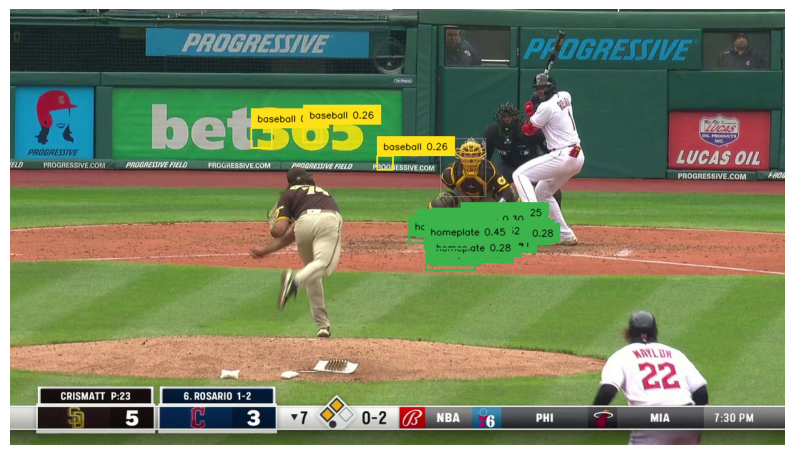

In [13]:
# Run inference
detections = model.inference(
    file_path=example_image,
    classes=classes,
    conf=0.25,  # Lower confidence threshold to see more detections
    save=True,
    save_viz_dir='baseball_detections'
)

## Display the results


In [15]:
# Print detection details
if len(detections) > 0:  # First check if we have any detections
    for class_id, confidence, bbox in zip(detections.class_id, detections.confidence, detections.xyxy):
        print(f"Class: {classes[int(class_id)]}")
        print(f"Confidence: {confidence:.2f}")
        print(f"Box coordinates (x1, y1, x2, y2): {bbox.tolist()}")
        print("---")
else:
    print("No detections found in the image")

Class: baseball
Confidence: 0.29
Box coordinates (x1, y1, x2, y2): [398.53839111328125, 196.8037109375, 432.7659912109375, 229.6023712158203]
---
Class: homeplate
Confidence: 0.47
Box coordinates (x1, y1, x2, y2): [723.887451171875, 390.7408752441406, 799.0831298828125, 403.5917663574219]
---
Class: homeplate
Confidence: 0.35
Box coordinates (x1, y1, x2, y2): [754.5020751953125, 379.43841552734375, 825.9844970703125, 393.9520568847656]
---
Class: homeplate
Confidence: 0.25
Box coordinates (x1, y1, x2, y2): [744.8993530273438, 351.6045227050781, 811.20458984375, 367.0979919433594]
---
Class: homeplate
Confidence: 0.37
Box coordinates (x1, y1, x2, y2): [749.890869140625, 389.1591796875, 822.58349609375, 402.93878173828125]
---
Class: homeplate
Confidence: 0.43
Box coordinates (x1, y1, x2, y2): [726.4508056640625, 382.0169982910156, 800.7261962890625, 395.6419982910156]
---
Class: homeplate
Confidence: 0.52
Box coordinates (x1, y1, x2, y2): [699.2830810546875, 409.8974609375, 778.43652343